<a href="https://colab.research.google.com/github/kalyanchakri02/ml-latest/blob/main/feature_training_catboost_gpu_repair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0:	learn: 0.9428966	test: 0.9487221	best: 0.9487221 (0)	total: 224ms	remaining: 1m 29s
100:	learn: 0.9694686	test: 0.9748559	best: 0.9748559 (64)	total: 21.7s	remaining: 1m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9748558627
bestIteration = 64

Shrink model to first 65 iterations.
Raw Features Only
Balanced Accuracy: 0.9695383522547346
F1 Macro: 0.9713380275286151
F1 Weighted: 0.9804768462070683

              precision    recall  f1-score   support

   No Action       0.99      0.98      0.99      5742
      Reboot       0.96      0.98      0.97      1770
      Reseat       0.97      0.98      0.97      1361
         RMA       0.98      0.94      0.96       127

    accuracy                           0.98      9000
   macro avg       0.97      0.97      0.97      9000
weighted avg       0.98      0.98      0.98      9000



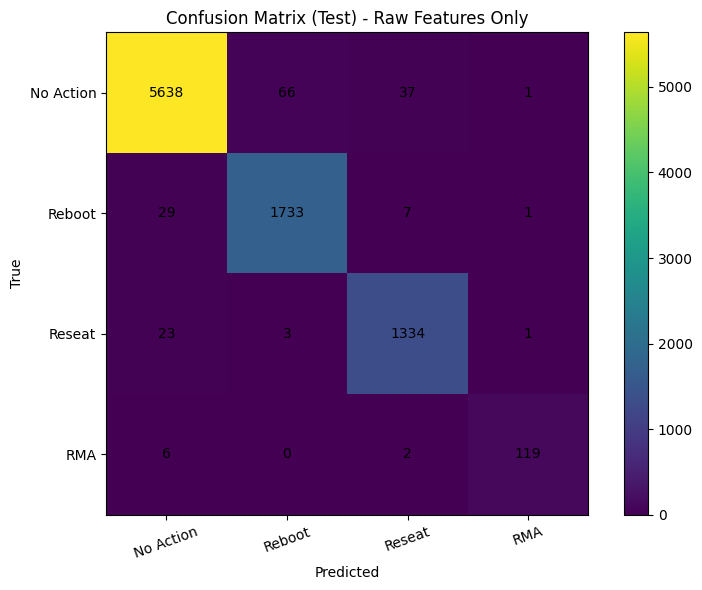

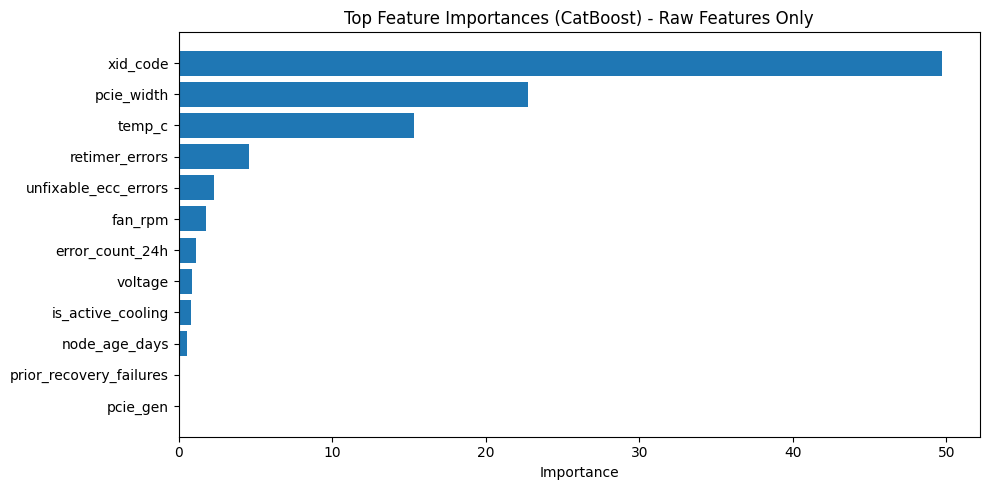

0:	learn: 0.9345804	test: 0.9426086	best: 0.9426086 (0)	total: 253ms	remaining: 1m 40s
100:	learn: 0.9687512	test: 0.9743614	best: 0.9743614 (97)	total: 27.9s	remaining: 1m 22s


In [ ]:
!pip install catboost

import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score
)
import matplotlib.pyplot as plt

# =============================================================================
# Reproducibility & dataset sizing
# =============================================================================
np.random.seed(42)
n_samples = 60000  # Reduced for faster notebook execution (increase for stronger stats)

# =============================================================================
# STEP 1: Generate a *latent* fault domain (hidden ground truth cause)
# -----------------------------------------------------------------------------
# This is NOT given to the model; it is used only to synthesize realistic signals.
# =============================================================================
fault_domains = np.random.choice(
    ["healthy", "software", "signal", "thermal", "silicon"],
    size=n_samples,
    p=[0.70, 0.12, 0.10, 0.06, 0.02]  # class imbalance similar to real fleets
)

# GPU SKU / model is an observed categorical attribute
gpu_model = np.random.choice(
    ["H100", "A100", "V100", "H200", "GB200"],
    n_samples,
    p=[0.30, 0.25, 0.20, 0.15, 0.10]
)

# Whether the GPU uses active cooling (fan on card) vs server/chassis fans
# Most data center GPUs are passive (fan is on chassis), hence p=[0.92, 0.08].
is_active_cooling = np.random.choice([0, 1], n_samples, p=[0.92, 0.08])

def normal_by_domain(dom, means, stds):
    """
    Draw a normal-distributed feature whose mean/std depend on fault domain.

    Parameters
    ----------
    dom : array[str]
        Per-sample domain label (latent).
    means, stds : dict[str, float]
        Mean and std per domain.

    Returns
    -------
    np.ndarray
        Feature values sampled per domain.
    """
    mu = np.vectorize(means.get)(dom)
    sd = np.vectorize(stds.get)(dom)
    return np.random.normal(mu, sd, size=len(dom))

# =============================================================================
# STEP 2: Synthesize observable telemetry/log signals
# -----------------------------------------------------------------------------
# Each signal is correlated with the latent fault domain to create learnable
# patterns, but still includes overlap/noise to avoid "perfect" separability.
# =============================================================================

# GPU temperature (thermal domain is hottest; silicon tends to run hotter too)
temp_c = normal_by_domain(
    fault_domains,
    means={"healthy": 70, "software": 72, "signal": 73, "thermal": 95, "silicon": 85},
    stds={"healthy": 10, "software": 12, "signal": 12, "thermal": 6, "silicon": 10},
)
temp_c = np.clip(temp_c, 20, 110)  # enforce physically plausible bounds

# Fan RPM (thermal tends to push fans high; other domains are more normal)
fan_rpm = normal_by_domain(
    fault_domains,
    means={"healthy": 2500, "software": 2600, "signal": 2550, "thermal": 4200, "silicon": 2600},
    stds={"healthy": 700, "software": 800, "signal": 800, "thermal": 600, "silicon": 800},
)
fan_rpm = np.clip(fan_rpm, 0, 6000)

# Voltage (silicon/power-related issues show more droop and variance)
voltage = normal_by_domain(
    fault_domains,
    means={"healthy": 1.20, "software": 1.20, "signal": 1.19, "thermal": 1.18, "silicon": 1.15},
    stds={"healthy": 0.06, "software": 0.06, "signal": 0.07, "thermal": 0.08, "silicon": 0.10},
)
voltage = np.clip(voltage, 0.8, 1.4)

# Retimer errors (signal integrity issues dominate; others have low background noise)
retimer_errors = np.random.poisson(
    lam=np.where(
        fault_domains == "signal", 6.0,
        np.where(
            fault_domains == "thermal", 0.6,
            np.where(
                fault_domains == "software", 0.4,
                np.where(fault_domains == "silicon", 1.0, 0.2)
            )
        )
    ),
    size=n_samples
)

# PCIe link width degradation is most common in signal/silicon domains
pcie_width = np.where(
    fault_domains == "signal",
    np.random.choice([16, 8, 4, 1], n_samples, p=[0.50, 0.30, 0.15, 0.05]),
    np.where(
        fault_domains == "silicon",
        np.random.choice([16, 8, 4, 1], n_samples, p=[0.40, 0.25, 0.20, 0.15]),
        np.random.choice([16, 8, 4, 1], n_samples, p=[0.94, 0.03, 0.02, 0.01])
    )
).astype(int)

# PCIe generation degradation pattern (similar story: signal/silicon show worse negotiation)
pcie_gen = np.where(
    fault_domains == "signal",
    np.random.choice([5, 4, 3, 2, 1], n_samples, p=[0.60, 0.20, 0.15, 0.03, 0.02]),
    np.where(
        fault_domains == "silicon",
        np.random.choice([5, 4, 3, 2, 1], n_samples, p=[0.55, 0.15, 0.15, 0.10, 0.05]),
        np.random.choice([5, 4, 3, 2, 1], n_samples, p=[0.88, 0.06, 0.03, 0.02, 0.01])
    )
).astype(int)

# XID codes represent driver/firmware/hardware fault signatures
xid_code = np.where(
    fault_domains == "software",
    np.random.choice(["XID_31", "XID_43", "XID_61", "NONE"], n_samples, p=[0.35, 0.30, 0.25, 0.10]),
    np.where(
        fault_domains == "signal",
        np.random.choice(["XID_79", "NONE", "XID_43"], n_samples, p=[0.45, 0.45, 0.10]),
        np.where(
            fault_domains == "silicon",
            np.random.choice(["XID_79", "NONE", "XID_61"], n_samples, p=[0.55, 0.25, 0.20]),
            np.random.choice(["NONE", "XID_31", "XID_43", "XID_61", "XID_79"], n_samples,
                             p=[0.92, 0.03, 0.02, 0.02, 0.01])
        )
    )
)

# Aggregate error counts in a 24h window (silicon dominates; healthy is low)
error_count_24h = np.random.poisson(
    lam=np.where(
        fault_domains == "silicon", 4.5,
        np.where(
            fault_domains == "thermal", 1.2,
            np.where(
                fault_domains == "signal", 1.0,
                np.where(fault_domains == "software", 0.8, 0.3)
            )
        )
    ),
    size=n_samples
)

# "Unfixable" ECC errors: rare but strongly associated with silicon failures
unfixable_ecc_errors = np.random.binomial(
    n=1,
    p=np.where(fault_domains == "silicon", 0.25, 0.003),
    size=n_samples
).astype(int)

# Node age and recovery history give temporal context (older nodes fail more often)
node_age_days = np.random.exponential(scale=180, size=n_samples).astype(int)
prior_recovery_failures = np.random.poisson(
    lam=np.where(
        fault_domains == "healthy", 0.05,
        np.where(
            fault_domains == "software", 0.2,
            np.where(
                fault_domains == "signal", 0.4,
                np.where(fault_domains == "thermal", 0.5, 1.2)
            )
        )
    ),
    size=n_samples
)

# Assemble the raw dataset (observables only)
df_raw = pd.DataFrame({
    "temp_c": temp_c,
    "fan_rpm": fan_rpm.astype(int),
    "voltage": voltage,
    "error_count_24h": error_count_24h,
    "pcie_width": pcie_width,
    "pcie_gen": pcie_gen,
    "retimer_errors": retimer_errors,
    "gpu_model": gpu_model,
    "xid_code": xid_code,
    "is_active_cooling": is_active_cooling.astype(int),
    "unfixable_ecc_errors": unfixable_ecc_errors,
    "node_age_days": node_age_days,
    "prior_recovery_failures": prior_recovery_failures
})

# =============================================================================
# STEP 3: Define the N-tier policy labels (what action should be taken)
# -----------------------------------------------------------------------------
# Labels represent the "recommended recovery tier":
#   0: No Action (healthy)
#   1: Reboot / power-cycle (software / recoverable)
#   2: Reseat / component fix (physical / signal integrity)
#   3: RMA (hard silicon failure)
# =============================================================================
def recommend_repair_action(row):
    # -------- Tier 3: RMA (hard failure signatures) --------
    if row["unfixable_ecc_errors"] > 0 or row["error_count_24h"] > 6:
        return 3
    if row["is_active_cooling"] == 1 and row["fan_rpm"] < 500 and row["temp_c"] > 85:
        return 3
    if row["xid_code"] == "XID_79" and row["pcie_width"] <= 1:
        return 3

    # -------- Tier 2: Physical intervention --------
    if row["is_active_cooling"] == 0 and row["fan_rpm"] < 500:
        return 2
    if row["pcie_width"] < 16:
        return 2
    if row["retimer_errors"] > 6:
        return 2
    if row["xid_code"] == "XID_79" and row["pcie_width"] > 1:
        return 2

    # -------- Tier 1: Recoverable / software/firmware --------
    if row["temp_c"] > 92 and row["fan_rpm"] >= 500:
        return 1
    if row["xid_code"] in ["XID_43", "XID_31", "XID_61"]:
        return 1

    # -------- Tier 0: Healthy --------
    return 0

# Apply the policy function to produce labels
df_raw["action_label"] = df_raw.apply(recommend_repair_action, axis=1)

# Inject label noise to simulate real-world ambiguity (missing logs, operator variance, etc.)
noise_rate = 0.03
flip_mask = np.random.rand(len(df_raw)) < noise_rate
df_raw.loc[flip_mask, "action_label"] = np.random.choice(
    [0, 1, 2, 3],
    size=flip_mask.sum(),
    p=[0.7, 0.15, 0.12, 0.03]
)

# =============================================================================
# STEP 4: Feature extraction (engineered features derived from raw observables)
# -----------------------------------------------------------------------------
# These mimic high-dimensional feature engineering used in production systems.
# =============================================================================
def add_extracted_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add derived / engineered features to strengthen separability between tiers.

    Notes
    -----
    - log transforms stabilize heavy-tailed counters (retimer/errors/history)
    - composite scores represent domain-specific risk signals
    - boolean flags allow trees to capture crisp decision boundaries
    """
    d = df.copy()
    eps = 1e-6  # protect divisions

    # --- Log transforms for count-like features (reduce skew) ---
    d["log_retimer_errors"] = np.log1p(d["retimer_errors"])
    d["log_error_count_24h"] = np.log1p(d["error_count_24h"])
    d["log_prior_recovery_failures"] = np.log1p(d["prior_recovery_failures"])
    d["log_node_age_days"] = np.log1p(d["node_age_days"])

    # --- Thermal / cooling features ---
    d["thermal_headroom"] = 110 - d["temp_c"]                     # distance from critical temp
    d["thermal_flag"] = (d["temp_c"] > 90).astype(int)            # simple hot indicator
    d["fan_efficiency"] = d["fan_rpm"] / (d["temp_c"] + eps)      # rpm per degree
    d["cooling_mismatch"] = (
        (d["is_active_cooling"] == 1) & (d["temp_c"] > 90) & (d["fan_rpm"] < 1200)
    ).astype(int)

    # --- Power features ---
    d["voltage_droop"] = 1.20 - d["voltage"]                      # droop relative to nominal
    d["droop_severity"] = np.maximum(0.0, 1.18 - d["voltage"])    # focus on “bad” droop region
    d["thermal_power_coupling"] = d["temp_c"] * d["voltage_droop"]# joint stress signal

    # --- Interconnect / signal integrity features ---
    d["pcie_bw_score"] = d["pcie_width"] * d["pcie_gen"]          # crude bandwidth proxy
    d["pcie_degraded"] = ((d["pcie_width"] < 16) | (d["pcie_gen"] < 5)).astype(int)
    d["signal_integrity_score"] = d["log_retimer_errors"] + 2.0 * d["pcie_degraded"]

    # --- Silicon risk features ---
    d["error_density"] = d["error_count_24h"] / (d["node_age_days"] + 1.0)
    d["ecc_present"] = d["unfixable_ecc_errors"].astype(int)
    d["silicon_risk_score"] = (
        3.0 * d["ecc_present"]
        + d["log_error_count_24h"]
        + 0.7 * np.maximum(0.0, d["voltage_droop"])
        + 0.3 * d["log_prior_recovery_failures"]
    )

    # --- XID one-hot style indicators (tree-friendly) ---
    d["xid_is_none"] = (d["xid_code"] == "NONE").astype(int)
    d["xid_is_bus"] = (d["xid_code"] == "XID_79").astype(int)
    d["xid_is_hang"] = d["xid_code"].isin(["XID_31", "XID_43"]).astype(int)
    d["xid_is_reset"] = (d["xid_code"] == "XID_61").astype(int)

    # --- History-based risk / pressure ---
    d["repeat_failure_flag"] = (d["prior_recovery_failures"] >= 2).astype(int)
    d["recovery_pressure"] = d["prior_recovery_failures"] / (d["node_age_days"] + 7.0)

    return d

df_full = add_extracted_features(df_raw)

# =============================================================================
# STEP 5: Train/Val/Test split (stratified to preserve class proportions)
# =============================================================================
target_names = ["No Action", "Reboot", "Reseat", "RMA"]
y = df_raw["action_label"]

# Create stable index splits so we can compare raw vs engineered features fairly
train_idx, temp_idx = train_test_split(
    df_raw.index,
    test_size=0.30,
    random_state=42,
    stratify=y
)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,
    random_state=42,
    stratify=y.loc[temp_idx]
)

# =============================================================================
# STEP 6: Training + evaluation helper
# -----------------------------------------------------------------------------
# This function trains CatBoost and reports:
# - Balanced accuracy (good for imbalance)
# - Macro F1 (treats classes equally)
# - Weighted F1 (accounts for class frequency)
# Plus confusion matrix and top feature importances.
# =============================================================================
def train_and_eval(X_df: pd.DataFrame, y_series: pd.Series, title: str):
    # Split by index to ensure identical train/val/test across experiments
    X_train = X_df.loc[train_idx]
    X_val   = X_df.loc[val_idx]
    X_test  = X_df.loc[test_idx]
    y_train = y_series.loc[train_idx]
    y_val   = y_series.loc[val_idx]
    y_test  = y_series.loc[test_idx]

    # Identify categorical columns for CatBoost (it handles encoding internally)
    cat_cols = [c for c in ["gpu_model", "xid_code"] if c in X_df.columns]
    cat_features = [X_df.columns.get_loc(c) for c in cat_cols]  # CatBoost expects indices

    # Class weights to compensate imbalance (esp. rare "RMA")
    counts = y_train.value_counts().sort_index()
    class_weights = (counts.sum() / (len(counts) * counts)).tolist()

    # CatBoost configuration tuned for multiclass + imbalance
    model = CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="TotalF1:average=Macro",  # prefer macro-F1 over raw accuracy
        iterations=400,
        learning_rate=0.08,
        depth=7,
        l2_leaf_reg=6,
        random_seed=42,
        class_weights=class_weights,
        od_type="Iter",   # early stopping
        od_wait=50,
        verbose=100
    )

    # Train with a validation set and keep best iteration
    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    # CatBoost predict() returns shape (n,1); convert to flat int array
    pred = model.predict(X_test).astype(int).reshape(-1)

    # Core metrics for paper reporting
    bal_acc = balanced_accuracy_score(y_test, pred)
    f1_macro = f1_score(y_test, pred, average="macro")
    f1_weighted = f1_score(y_test, pred, average="weighted")

    # ---- Print metrics + full per-class report ----
    print("=" * 90)
    print(title)
    print("Balanced Accuracy:", bal_acc)
    print("F1 Macro:", f1_macro)
    print("F1 Weighted:", f1_weighted)
    print()
    print(classification_report(y_test, pred, target_names=target_names))

    # ---- Confusion matrix visualization ----
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm)
    plt.xticks(range(4), target_names, rotation=20)
    plt.yticks(range(4), target_names)
    plt.title(f"Confusion Matrix (Test) - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    for i in range(4):
        for j in range(4):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()

    # ---- Feature importance (top 12) ----
    imp = (
        pd.Series(model.get_feature_importance(), index=X_df.columns)
        .sort_values(ascending=False)
        .head(12)
    )
    plt.figure(figsize=(10, 5))
    plt.barh(imp.index[::-1], imp.values[::-1])
    plt.title(f"Top Feature Importances (CatBoost) - {title}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    return {"title": title, "balanced_accuracy": bal_acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}

# =============================================================================
# STEP 7: Run two experiments
#   (A) Raw observables only
#   (B) Raw + engineered features
# =============================================================================
X_raw = df_raw.drop(columns=["action_label"])
res_raw = train_and_eval(X_raw, y, "Raw Features Only")

X_full = df_full.drop(columns=["action_label"])
res_full = train_and_eval(X_full, y, "Raw + Extracted Features")

# Summarize results for quick comparison (useful for paper tables)
summary = pd.DataFrame([res_raw, res_full])
summary
